In [7]:
import jax.random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
import optax
tfd = tfp.distributions
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Gibbs sampler for Gaussian Mixture Model (GMM)

In this notebook, we will apply the Gibbs-Langevin sampler to infer the parameters of a Gaussian Mixture Model (GMM) using observations from the distribution. The full joint distribution is given by:


$$
p(\boldsymbol{x}, \boldsymbol{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}) = p(\boldsymbol{x}|\boldsymbol{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma})p(\boldsymbol{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \prod_{k=1}^K p(\boldsymbol{\mu}_k)p(\boldsymbol{\Sigma}_k)
$$

$$
= \left(\prod_{i=1}^N \prod_{k=1}^K (\pi_k \mathcal{N}(\boldsymbol{x}_i|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k))^{\mathbb{I}(z_i=k)}\right) \times
$$

$$
\text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}) \prod_{k=1}^K \mathcal{N}(\boldsymbol{\mu}_k|\boldsymbol{m}_0, \mathbf{V}_0)\text{IW}(\boldsymbol{\Sigma}_k|\mathbf{S}_0, \nu_0)
$$


Given samples $\boldsymbol{x}$, we will infer the latent variables $\boldsymbol{z}$, the mixture weights $\boldsymbol{\pi}$, the means $\boldsymbol{\mu}$ and the covariance matrices $\boldsymbol{\Sigma}$.
    


#### Generate data from ground truth GMM

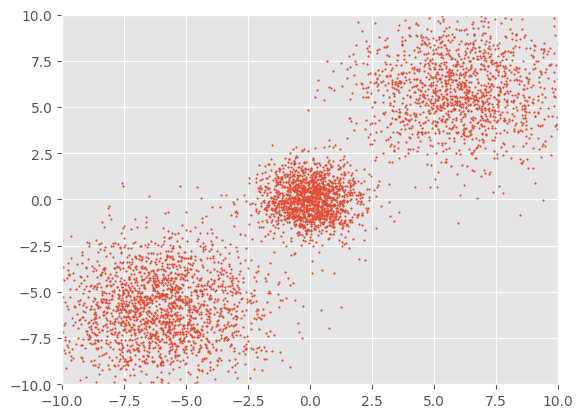

In [3]:
seed = 0
rng = random.PRNGKey(seed)
weights = jnp.array([0.4, 0.3, 0.3])
# Number of training samples
num_samples = 5000
dtype = np.float32
# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = jnp.array([[-6, -6],
                     [0, 0],
                     [6, 6]], dtype)

true_scale = jnp.array([[2.0, 2.0], 
                        [1.0, 1.0], 
                        [2.0, 2.0]])

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
# true_hidden_component = random.randint(rng, shape=(num_samples,), minval=0, maxval=true_components_num)
# observations = true_loc[true_hidden_component] + random.normal(rng, shape=(num_samples, dims))
gmm_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=true_loc, scale_diag=true_scale))
observations = gmm_dist.sample(seed=rng, sample_shape=(num_samples,))
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

### Full conditional distributions
The full conditional distribution for each parameter is given by:

1. $\boldsymbol{z}_i$: The latent variable for each observation $i$ is given by:
$$
p(z_i=k|\boldsymbol{x}_i, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}) \propto \pi_k \mathcal{N}(\boldsymbol{x}_i|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

2. For the mixture weights $\boldsymbol{\pi}$, we have:
$$
p(\boldsymbol{\pi}|\boldsymbol{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \text{Dir}(\{\alpha_k + \sum_{i=1}^N \mathbb{I}(z_i=k)\}_{k=1}^K)
$$
3. For the means $\boldsymbol{\mu}$, we have:
$$
\begin{align*}
p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k, \boldsymbol{z}, \boldsymbol{x}) &= \mathcal{N}(\boldsymbol{\mu}_k|\boldsymbol{m}_k, \mathbf{V}_k) \\
\mathbf{V}_k^{-1} &= \mathbf{V}_0^{-1} + N_k\boldsymbol{\Sigma}_k^{-1} \\
\boldsymbol{m}_k &= \mathbf{V}_k(\boldsymbol{\Sigma}_k^{-1}N_k\bar{\boldsymbol{x}}_k + \mathbf{V}_0^{-1}\boldsymbol{m}_0) \\
N_k &\triangleq \sum_{i=1}^N \mathbb{I}(z_i = k) \\
\bar{\boldsymbol{x}}_k &\triangleq \frac{\sum_{i=1}^N \mathbb{I}(z_i = k)\boldsymbol{x}_i}{N_k}
\end{align*}
$$
4. Since the component-wise distributions are isotropic Gaussians, we use the Gamma distribution to model the inverse variances (precision) instead of the Inverse-Wishart distribution.:
$$
\begin{align*}
p(\boldsymbol{\sigma}^{-2} | \mathbf{x}, \mathbf{z}, \boldsymbol{\mu}) &= \prod_{k=1}^K \text{Gamma}(\sigma_k^{-2} | a_k, b_k) \\
\text{where:} \\
a_k &= a_{0k} + \frac{N_k}{2} \\
b_k &= b_{0k} + \frac{1}{2}\sum_{i: z_i = k} (x_i - \mu_k)^2 \\
N_k &= \sum_{i=1}^N \mathbb{I}(z_i = k)
\end{align*}
$$
The following code block defines the full conditional distributions for each parameter.

In [129]:
EPS = 1e-12
from tensorflow_probability.python.internal.backend.jax.compat import v2 as tf

def get_log_prob_z_nd(x) :
    def get_per_comp_log_p(xi, pi_k, mu_k, sigma_k):
        logp = tfd.MultivariateNormalFullCovariance(mu_k, jnp.diag(sigma_k)).log_prob(xi)
        return logp + jnp.log(pi_k + EPS)
    
    def log_prob_fn(z, state):
        pi = state["pi"]
        mu, sigma = state["mu"], state["sigma"]
        pi = jax.nn.softmax(pi, axis=-1)
        sigma = 1./jax.nn.softplus(sigma)
        logits = jax.vmap(lambda i: jax.vmap(get_per_comp_log_p, 
                                             in_axes=(None, 0, 0, 0))(i, pi, mu, sigma))(x)
        log_prob = jax.vmap(lambda i, k: -tf.nn._softmax_cross_entropy_with_logits(logits=i, labels=k))(logits, z)
        return jnp.sum(log_prob)
    
    return log_prob_fn

def get_log_prob_mu_nd(x, mu_0, sigma_0, num_comps):
    
    def get_per_comp_log_p(k, m, sigma_k, z):
        idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
        idx_k = jnp.sum(idx, axis=-1) == num_comps
        n_k = jnp.sum(idx_k)
        x_k =  jnp.sum(jnp.where(idx_k[:,None], x, 0), axis=0) / jnp.where(n_k > 0, n_k, 1.)
        v_0_k = jnp.diag(sigma_0[k])
        sigma_k = jnp.diag(sigma_k)
        v_0_inv = jnp.linalg.inv(v_0_k)
        sigma_k_inv = jnp.linalg.inv(sigma_k)
        
        v_k_inv = v_0_inv + n_k*sigma_k_inv
        v_k = jnp.linalg.inv(v_k_inv)
        
        m_k = v_k @ (sigma_k_inv@(n_k*x_k) + mu_0[k]*v_0_inv)
        log_p = tfd.MultivariateNormalFullCovariance(m_k, v_k).log_prob(m)
        return log_p
    
    def log_prob_fn(mu, state):
        sigma = state["sigma"]
        z = state["z"]
        sigma = 1./jax.nn.softplus(sigma)
        log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), mu, sigma, z)
        return jnp.sum(log_probs)
    
    return log_prob_fn

def get_log_prob_sigma_nd(x, a_0, b_0, num_comps):

        def get_per_comp_log_p(k, sigma_k, mu_k, z):
            idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
            idx_k = jnp.sum(idx, axis=-1) == num_comps
            n_k = jnp.sum(idx_k)
            a_k = a_0[k] + n_k/2
            rss = jnp.sum((idx_k[:,None]*(x - mu_k)**2), axis=0)
            b_k = b_0[k] + rss/2
            log_p = tfd.Gamma(a_k, b_k).log_prob(sigma_k)
            return jnp.sum(log_p)


        def log_prob_fn(sigma, state):
            z = state["z"]
            mu = state["mu"]
            sigma = 1./jax.nn.softplus(sigma)
            log_probs = jax.vmap(get_per_comp_log_p, in_axes=(0, 0, 0, None))(jnp.arange(num_comps), sigma, mu, z)
            return jnp.sum(log_probs)

        return log_prob_fn

def get_log_prob_pi(alpha, num_comps):
    def get_concentrations(k, z):
        idx = jax.nn.one_hot(z, num_comps) == jax.nn.one_hot(k, num_comps)
        idx_k = jnp.sum(idx, axis=-1) == num_comps
        n_k = jnp.sum(idx_k)
        alpha_k = alpha[k]
        return (alpha_k + n_k) / num_comps

    def log_prob_fn(pi, state):
        z = state["z"]
        concentrations = jax.vmap(get_concentrations, in_axes=(0, None))(jnp.arange(num_comps), z)
        log_probs = tfd.Dirichlet(concentrations).log_prob(jax.nn.softmax(pi, axis=-1))
        return log_probs

    return log_prob_fn

### Gibbs-Langevin Sampler
The Gibbs-Langevin sampler is used to infer the unknown parameters. For the continuous parameters, $\boldsymbol{\pi}, \boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ we use the [Stochastic Gradient Hamiltonian Monte Carlo](http://arxiv.org/abs/1402.4102) (SGHMC) and for the discrete parameter, $\boldsymbol{z}$, we use the [Discrete Metropolis Adjusted Langevin](http://arxiv.org/abs/2206.09914) sampler (DMALA)

In [130]:
%autoreload
from sampler import *
step_sizes = {"z": 0.1, "pi": 0.1, "mu": 0.1, "sigma": 0.1}
k = len(weights)
dim = 2
a_0, b_0 = jnp.ones(k), jnp.ones(k)
mu_0 = random.uniform(rng, shape=(k, dim), minval=-9, maxval=9)
v_0 = jnp.ones((k, dim))
alpha = jnp.ones(k)
sigma = jnp.ones((k, dim))
log_probs = {
    "z": get_log_prob_z_nd,
    "pi": get_log_prob_pi,
    "mu": get_log_prob_mu_nd,
    "sigma": get_log_prob_sigma_nd
}
samples, accept_probs = gibbs_sampler(seed=0, data=observations, log_probs=log_probs, step_sizes=step_sizes,
                                        num_components=k, mu_0=mu_0, v_0=v_0, alpha=alpha,
                                        a_0=a_0, b_0=b_0, n_iters=2000, burn_in=1000, 
                                      mh=True)
print(f"Acceptance probs - mu: {accept_probs['mu'].mean()}, sigma: {accept_probs['sigma'].mean()}, pi: {accept_probs['pi'].mean()}, z: {accept_probs['z'].mean()}")

100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 87.81it/s]


Acceptance probs - mu: 0.5045, sigma: 0.5101574159235842, pi: 0.501, z: 0.502


In [131]:
jnp.mean(jax.nn.softmax(jnp.array(samples["pi"]), axis=-1), axis=0)

Array([0.3386503 , 0.26718768, 0.39416203], dtype=float32)

In [132]:
jnp.mean(jnp.array(samples["mu"]), axis=0)

Array([[ 0.06352654, -0.50572735],
       [ 7.254647  ,  5.084754  ],
       [-6.266058  , -5.891923  ]], dtype=float32)

In [133]:
jnp.mean(jax.nn.softplus(jnp.array(samples["sigma"])), axis=0) #TODO check sigma

Array([[2.244527 , 6.097055 ],
       [5.73843  , 4.528268 ],
       [4.0925136, 3.5407317]], dtype=float32)

In [134]:
def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

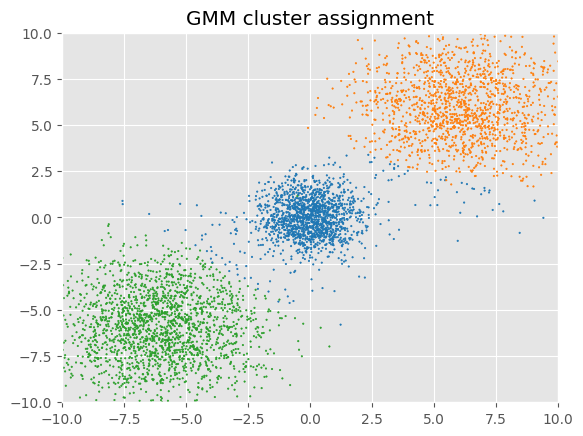

In [135]:
cluster_assignment = convert_int_elements_to_consecutive_numbers_in(np.array(samples["z"][-1]))
cmap = plt.get_cmap('tab10')
plt.title("GMM cluster assignment")
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_assignment)))
plt.axis([-10, 10, -10, 10])
plt.show()